# Quantifying the impact of exchange rate volatility for Monero-denominated delayed payouts

Isthmus / Mitchell Krawiec-Thayer ([isthmus@getmonero.org](mailto:isthmus@getmonero.org))

Monero contributors fundraising through the [Monero community crowdfunding system](https://ccs.getmonero.org/) must provide an monero-denominated quote for services up-front, often for payout weeks or months later upon project or milestone completion. The Monero exchange rate fluctuates significantly over these timescales.

At the time of writing, most contributors need to pay their regular rent/tuition/food/etc bills in fiat currency. Exchange rate volatility resulting in loss of monero's buying power effectively reduces contributor compensation. To protect against this, proposals often include a volatility buffer. Rather than relying on gut intuition or short term market trends, this notebook analyzes exchange rate volatility over the last few years to suggest a statistically-appropriate buffer.

**This method utilizes sliding window statistics over the monero/fiat exchange rate time series.** The window width is determined by the time between quote issuance and payout. The length of the time series should be long enough to avoid recency bias, and short enough to remain representative (conditions in 2020 vary significantly from 2015). Here, we use 4 months for the window width (1 month to fundraise + 3 months to complete work), and the last 2 years for the timeseries length. 

The cumulative distribution function is used to quantitatively estimate the volatility buffer necessary to provide a certain level of statistically confidence in receiving the correct payout. This can be formulated:

>[INPUTS:] Based on the last W years of data, X% confidence of adequate payout delayed by Y months requires an 
[OUTPUT:] Z% buffer.

Window width depends on each project's timeline and the timeseries length is somewhat subjective, so this research is deliberately shared as an interactive notebook. The next cell allows you to adjust the model's window width and input data:

## Set model parameters

In [1]:
days_quote_to_pay = 120; # width of sliding window
timeseries_length_days = 2*365 # two years
path_to_price_data = 'data/xmr_exchange_rate_all.csv';
asset_full_name = 'Monero'
asset_ticker = 'XMR'

## Import libraries

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22});

## Import data

In [3]:
if asset_ticker == 'XMR':
    df_all = pd.read_csv(path_to_price_data, names = ['date', 'USD_per_' + asset_ticker], skiprows=1);
    df_all.head() # take a peek to make sure it imported correctly

## Visualize the data

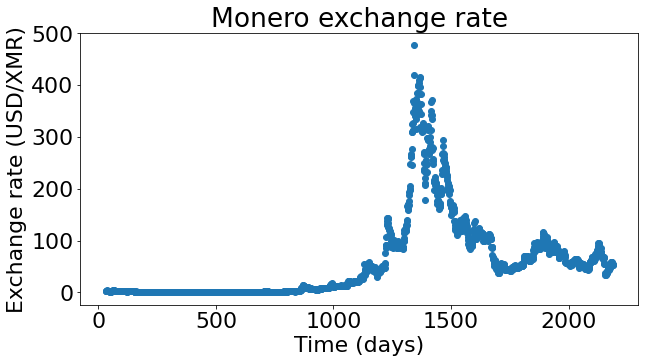

In [4]:
f = plt.figure(figsize=(10,5), facecolor='white');
plt.scatter(range(len(df_all)), df_all['USD_per_'+asset_ticker]);
plt.xlabel('Time (days)');
plt.ylabel('Exchange rate (USD/'+asset_ticker+')');
plt.title(asset_full_name + ' exchange rate');

## Feature engineering

Slide a window (of width `days_quote_to_pay` over the exchange rate timeseries)

In [5]:
gain_loss_buffer = list(np.full(days_quote_to_pay, np.nan));
for r in range(len(df_all)-days_quote_to_pay):
    price_at_quote = df_all.iloc[r]['USD_per_' + asset_ticker];
    price_at_payout = df_all.iloc[r+days_quote_to_pay]['USD_per_' + asset_ticker];
    gain_loss_buffer.append((price_at_payout-price_at_quote)/price_at_quote*100);
    
df_all['gain_loss'] = gain_loss_buffer;

<ipython-input-5-cc4f93017e1f>:5: RuntimeWarning: divide by zero encountered in double_scalars
  gain_loss_buffer.append((price_at_payout-price_at_quote)/price_at_quote*100);
<ipython-input-5-cc4f93017e1f>:5: RuntimeWarning: invalid value encountered in double_scalars
  gain_loss_buffer.append((price_at_payout-price_at_quote)/price_at_quote*100);


## Select input timeseries

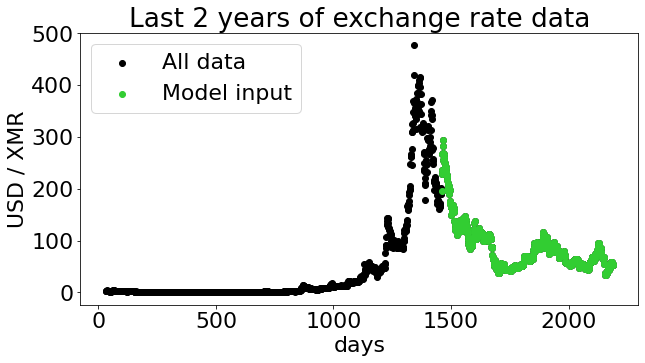

In [6]:
df = df_all[(len(df_all)-timeseries_length_days):len(df_all)]

fig = plt.figure(facecolor='white', figsize=(10,5))
tr_all = plt.scatter(range(len(df_all)), df_all['USD_per_' + asset_ticker],color='black')
tr_input = plt.scatter(range(len(df_all) - timeseries_length_days, len(df_all)), df['USD_per_' + asset_ticker], color='limegreen')
plt.legend(('All data', 'Model input'))
plt.xlabel('days')
plt.ylabel('USD / ' + asset_ticker)
plt.title('Last 2 years of exchange rate data');

## Review sliding window outcomes

The below histogram shows the probability distribution of outcomes. 

A value of 0 on the x-axis indicates that the exchange rate for the payout exactly matched the exchange rate when the quote was issued 4 months prior. A negative value on the x-axis indicates that the USD/XMR ratio decreased and monero lost spending power, so a contributor responsible for fiat-denominated bills experiences a reduction in compensation. (Likewise, a positive value indicates the opposite, that monero has gained spending power over the window.)

We observe an asymmetry over the past two years, for example: contributors were 2x as likely to experience a 50% loss in compensation (red line) than a 50% increase in compensation (green line)

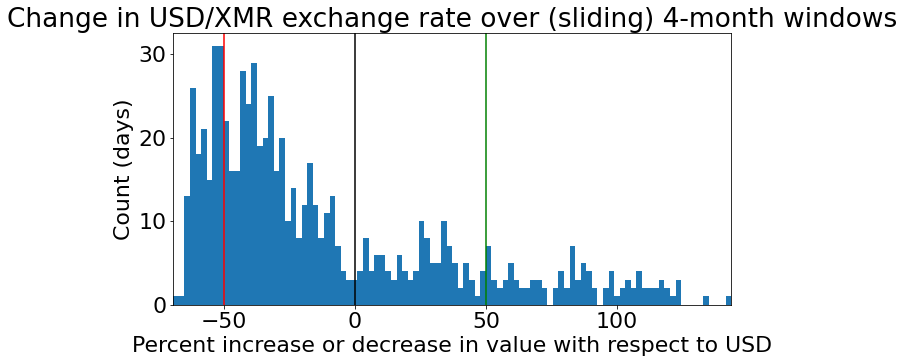

In [7]:
f = plt.figure(figsize=(10,5), facecolor='white');
plt.hist(df["gain_loss"].dropna(),bins=100);
plt.xlim((min(df['gain_loss'].dropna()),max(df['gain_loss'].dropna())));
plt.xlabel("Percent increase or decrease in value with respect to USD");
plt.ylabel('Count (days)');
plt.title('Change in USD/'+asset_ticker+' exchange rate over (sliding) 4-month windows');
plt.axvline(x=-50, color='red');
plt.axvline(x=+50, color='green');
plt.axvline(x=0, color='black');


In addition to the probability distribution function shown above, it's also informative to view the cumulative distribution function below. The red lines highlight that **over the last 2 years, the USD/XMR exchange rate decreased over 65% of 4-month windows.** In other words, only 35% of contributors would have received a payout that covers the quoted price.

The orange lines show that an 80% likelihood of receiving a sufficent payout can be achieved with a +35% buffer.

Formulating as above,

>[INPUTS:] Based on the last W years of data, X% confidence of adequate payout delayed by Y months requires an 
[OUTPUT:] Z% buffer.
>
> **Based on the last 2 years of data, 80% confidence of adequate payout delayed by 4 months requires a 35% buffer.**

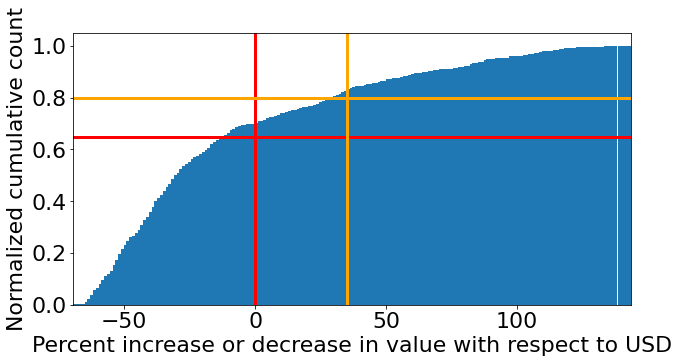

In [8]:
f = plt.figure(figsize=(10,5), facecolor='white');
plt.hist(df['gain_loss'].dropna(), bins=200, cumulative=True, density=True);
plt.xlabel("Percent increase or decrease in value with respect to USD");
plt.ylabel('Normalized cumulative count');
plt.xlim((min(df['gain_loss'].dropna()),max(df['gain_loss'].dropna())));
plt.axhline(y=0.65, color='red', linewidth=3);
plt.axvline(x=0, color='red', linewidth=3);
plt.axhline(y=0.80, color='orange', linewidth=3);
plt.axvline(x=35, color='orange', linewidth=3);

A volatility buffer is intended to protect the contributor against exchange rate decreases over the period of work.

**If the volatility buffer is set by the median value of exchange rate ratios, then we statistically expect:** 50% of contributors will experience a loss of spending power (of any magnitude) and 50% will experience a gain in spending power (of any magnitude). 

Notes: (1) If anything less than the median value is used,  there is *more than a 50% chance* that the fiat value of the quoted price will not be received upon xmr-denominated payout. (2) The median value was chosen for robustness to outliers (if the mean is used, then 1 contributor who lucks out with 150% increase cancels out 3 contributors who suffer a significant 50% loss, obscuring the fact that 3 of the 4 experienced a negative outcome)

A safer bet is median + standard deviation, in which case 74% of contributors will see an receive at least the expected payout. 

In [9]:
print('Median exchange rate ratio = ' + str(int(np.nanmedian(df['gain_loss'])))+'%');
print('Exchange rate ratio standard deviation = ' + str(int(np.nanstd(df['gain_loss'])))+'%');

Median exchange rate ratio = -30%
Exchange rate ratio standard deviation = 47%


## What about a longer timeframe?

I was asked about how the results change if we doubled the timeframe (so that the data include a bull market as well as cryptowinter). Let's take a look.

The plots in previous tweets spanned the last 2 years (green data points); now let's extend this to 4 years (green and blue data points).

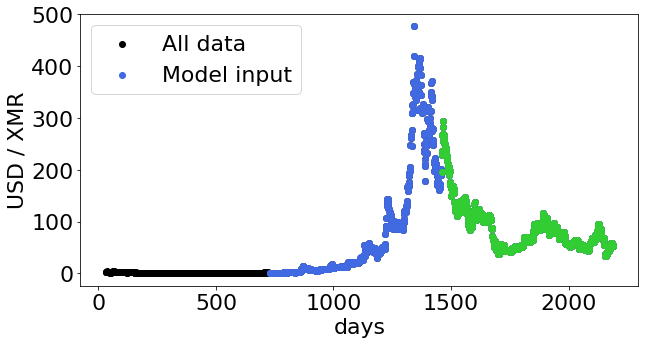

In [10]:
timeseries_cache = timeseries_length_days
timeseries_length_days = 4*365 # four years

df_cache = df
df = df_all[(len(df_all)-timeseries_length_days):len(df_all)]
df = df.replace([np.inf, -np.inf], np.nan)

fig = plt.figure(facecolor='white', figsize=(10,5))
tr_all = plt.scatter(range(len(df_all)), df_all['USD_per_' + asset_ticker], color='black')
tr_input = plt.scatter(range(len(df_all) - timeseries_length_days, len(df_all)), df['USD_per_' + asset_ticker], color='royalblue')
tr_old_input = plt.scatter(range(len(df_all) - timeseries_cache, len(df_all)), df_cache['USD_per_' + asset_ticker],color='limegreen')
plt.legend(('All data', 'Model input'))
plt.xlabel('days')
plt.ylabel('USD / ' + asset_ticker);

Now that our we include both the bull run leading up to the all time high *and* the subsequent decay, the extended data set contains new outcomes on both sides of the red breakeven line

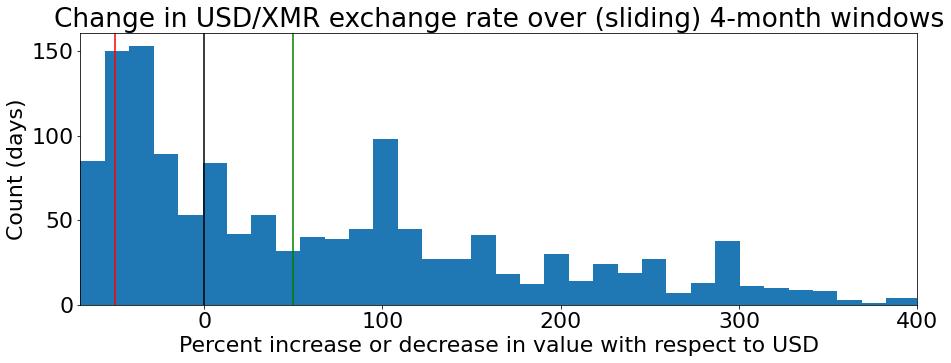

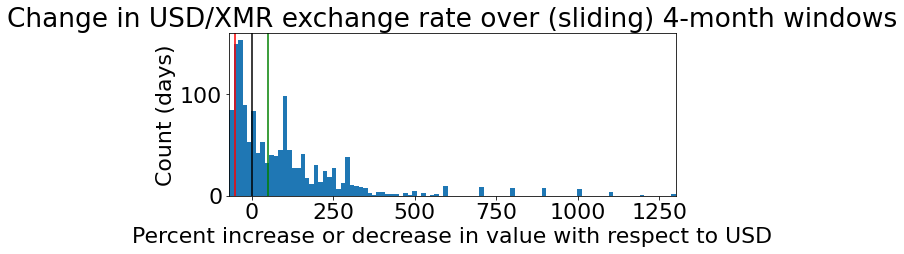

In [11]:
# Main body of outcomes
f = plt.figure(figsize=(15,5), facecolor='white');
plt.hist(df["gain_loss"].dropna(),bins=100);
plt.xlim((min(df['gain_loss'].dropna()),400));
plt.xlabel("Percent increase or decrease in value with respect to USD");
plt.ylabel('Count (days)');
plt.title('Change in USD/'+asset_ticker+' exchange rate over (sliding) 4-month windows');
plt.axvline(x=0, color='black');
plt.axvline(x=-50, color='red');
plt.axvline(x=+50, color='green');

# Show the outliers
f = plt.figure(figsize=(8,3), facecolor='white');
plt.hist(df["gain_loss"].dropna(),bins=100);
plt.xlim((min(df['gain_loss'].dropna()),max(df['gain_loss'].dropna())));
plt.xlabel("Percent increase or decrease in value with respect to USD");
plt.ylabel('Count (days)');
plt.title('Change in USD/'+asset_ticker+' exchange rate over (sliding) 4-month windows');
plt.axvline(x=-50, color='red');
plt.axvline(x=0, color='black');
plt.axvline(x=+50, color='green');

Over the 4 year history, we see that about 60% of the windows receive a payout covering the quoted value (red cross). Since the data set now includes an 8x bubble in its entirety, the volatility insurance rate for 80% confidence rises to a 170% buffer (orange cross).


>[INPUTS:] Based on the last W years of data, X% confidence of adequate payout delayed by Y months requires an 
[OUTPUT:] Z% buffer.
>
> **Based on the last 4 years of data, 80% confidence of adequate payout delayed by 4 months requires a 170% buffer.**

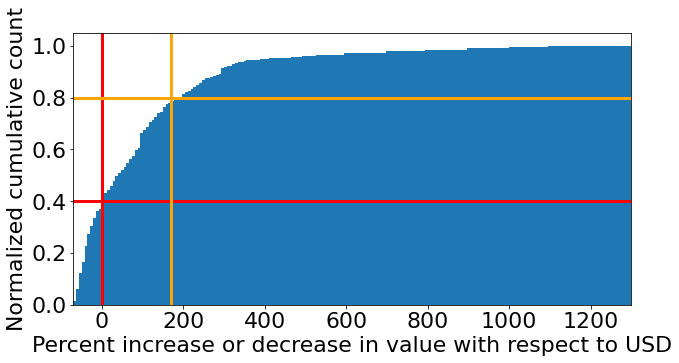

In [12]:
f = plt.figure(figsize=(10,5), facecolor='white');
plt.hist(df['gain_loss'].dropna(), bins=200, cumulative=True, density=True);
plt.xlabel("Percent increase or decrease in value with respect to USD");
plt.ylabel('Normalized cumulative count');
plt.xlim((min(df['gain_loss'].dropna()),max(df['gain_loss'].dropna())));
plt.axhline(y=0.4, color='red', linewidth=3);
plt.axvline(x=0, color='red', linewidth=3);
plt.axhline(y=0.80, color='orange', linewidth=3);
plt.axvline(x=170, color='orange', linewidth=3);